In [ ]:
%pip install seaborn

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

In [2]:
# Assuming preprocessed dataset is loaded as X_train, y_train, X_test, y_test
train_df: pd.DataFrame = pd.read_csv('train.csv')
test_df: pd.DataFrame = pd.read_csv('test.csv')

In [3]:
# Alley identifica o tipo de rua que dá acesso a casa por um beco, quando tem
# Trata trocando o valor NaN por noAlley
train_df['Alley'] = train_df['Alley'].fillna('noAlley')

In [4]:
# FireplaceQu é indicador da qualidade da lareira, quando não tem, está com o valor NaN
# Trata isso colocando noFireplace no lugar
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna('noFireplace')

In [5]:
# Fence indica a qualidade da cerca, quando não tem está com valor NaN
# Trata isso colocando noFence no lugar
train_df['Fence'] = train_df['Fence'].fillna('noFence')

In [6]:
# PoolQC, PoolArea, MiscFeature and MiscVal have to many NaN values and may not correlate with SalePrice
# Handle it by droping those columns from the data
train_df.drop(['PoolQC', 'PoolArea', 'MiscFeature', 'MiscVal'], axis = 1, inplace = True)

In [7]:
# Alley identifica o tipo de rua que dá acesso a casa por um beco, quando tem
# Trata trocando o valor NaN por noAlley
train_df['Alley'] = train_df['Alley'].fillna('noAlley')
test_df['Alley'] = test_df['Alley'].fillna('noAlley')

# MasVnrType identifica o tipo de revestimento de alvenaria
# Trata trocando o valor NaN por None
train_df['MasVnrType'] = train_df['MasVnrType'].fillna('None')
test_df['MasVnrType'] = test_df['MasVnrType'].fillna('None')

# MasVnrArea identifica a área de revestimento de alvenaria
# Trata trocando o valor NaN por 0
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(0)

# BsmtQual identifica a altura do porão
# Trata trocando o valor NaN por noBsmt
train_df['BsmtQual'] = train_df['BsmtQual'].fillna('noBsmt')
test_df['BsmtQual'] = test_df['BsmtQual'].fillna('noBsmt')

# FireplaceQu é indicador da qualidade da lareira, quando não tem, está com o valor NaN
# Trata isso colocando noFireplace no lugar
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna('noFireplace')
test_df['FireplaceQu'] = test_df['FireplaceQu'].fillna('noFireplace')

# Fence indica a qualidade da cerca, quando não tem está com valor NaN
# Trata isso colocando noFence no lugar
train_df['Fence'] = train_df['Fence'].fillna('noFence')
test_df['Fence'] = test_df['Fence'].fillna('noFence')

# GarageType indica o tipo de garagem, quando não tem está com valor NaN
# Trata isso colocando noGarage no lugar
train_df['GarageType'] = train_df['GarageType'].fillna('noGarage')
test_df['GarageType'] = test_df['GarageType'].fillna('noGarage')

# PoolQC, PoolArea, MiscFeature and MiscVal have too many NaN values and may not correlate with SalePrice
# Handle it by droping those columns from the data
test_df.drop(columns=['PoolQC', 'PoolArea', 'MiscFeature', 'MiscVal'], inplace=True)

# MSSubClass is a categorical feature, so it should be treated as such
# Handle it by turning the numbers into letters (e.g. 20 -> A, 30 -> B, etc) and then one-hot encode it
train_df = pd.get_dummies(train_df, columns=['MSSubClass'])
test_df = pd.get_dummies(test_df, columns=['MSSubClass'])

# Some of the categorical features are ordinal and nominal, so they should be treated differently
# Handle all of the nominal features by one-hot encoding them
# MSZoning, Street, Alley, LotConfig, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, Electrical, GarageType, PavedDrive, SaleType, SaleCondition, LandContour,
train_df = pd.get_dummies(train_df, columns=['MSZoning', 'Street', 'Alley', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition', 'LandContour'])
test_df = pd.get_dummies(test_df, columns=['MSZoning', 'Street', 'Alley', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition', 'LandContour'])

# Handle all of the ordinal features by mapping them to numbers
# ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, CentralAir, KitchenQual, Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond, Fence, LotShape, Utilities
ordinal_map = {
'Ex': 5,
'Av': 4,
'Gd': 4,
'Mn': 3,
'TA': 3,
'Fa': 2,
'No': 2,
'Po': 1,
'Na': 1,
'GLQ': 6,
'ALQ': 5,
'BLQ': 4,
'Rec': 3,
'LwQ': 2,
'Unf': 1,
'Sal': 0,
'Sev': 1,
'Maj2': 2,
'Maj1': 3,
'Mod': 4,
'Min2': 5,
'Min1': 6,
'Typ': 7,
'Fin': 3,
'RFn': 2,
'Unf': 1,
'GdPrv': 4,
'MnPrv': 3,
'GdWo': 2,
'MnWw': 1,
'Reg': 4,
'IR1': 3,
'IR2': 2,
'IR3': 1,
'AllPub': 4,
'NoSewr': 3,
'NoSeWa': 2,
'ELO': 1,
'noBsmt': 0,
'noFireplace': 0,
'noFence': 0,
'noGarage': 0,
'noPool': 0,
'noMisc': 0,
'noAlley': 0
}
# Apply the mapping to the ordinal features

train_df['ExterQual'] = train_df['ExterQual'].map(ordinal_map)
test_df['ExterQual'] = test_df['ExterQual'].map(ordinal_map)
train_df['ExterCond'] = train_df['ExterCond'].map(ordinal_map)
test_df['ExterCond'] = test_df['ExterCond'].map(ordinal_map)
train_df['BsmtQual'] = train_df['BsmtQual'].map(ordinal_map)
test_df['BsmtQual'] = test_df['BsmtQual'].map(ordinal_map)
train_df['BsmtCond'] = train_df['BsmtCond'].map(ordinal_map)
test_df['BsmtCond'] = test_df['BsmtCond'].map(ordinal_map)
train_df['BsmtExposure'] = train_df['BsmtExposure'].map(ordinal_map)
test_df['BsmtExposure'] = test_df['BsmtExposure'].map(ordinal_map)
train_df['BsmtFinType1'] = train_df['BsmtFinType1'].map(ordinal_map)
test_df['BsmtFinType1'] = test_df['BsmtFinType1'].map(ordinal_map)
train_df['BsmtFinType2'] = train_df['BsmtFinType2'].map(ordinal_map)
test_df['BsmtFinType2'] = test_df['BsmtFinType2'].map(ordinal_map)
train_df['HeatingQC'] = train_df['HeatingQC'].map(ordinal_map)
test_df['HeatingQC'] = test_df['HeatingQC'].map(ordinal_map)
train_df['KitchenQual'] = train_df['KitchenQual'].map(ordinal_map)
test_df['KitchenQual'] = test_df['KitchenQual'].map(ordinal_map)
train_df['Functional'] = train_df['Functional'].map(ordinal_map)
test_df['Functional'] = test_df['Functional'].map(ordinal_map)
train_df['FireplaceQu'] = train_df['FireplaceQu'].map(ordinal_map)
test_df['FireplaceQu'] = test_df['FireplaceQu'].map(ordinal_map)
train_df['GarageFinish'] = train_df['GarageFinish'].map(ordinal_map)
test_df['GarageFinish'] = test_df['GarageFinish'].map(ordinal_map)
train_df['GarageQual'] = train_df['GarageQual'].map(ordinal_map)
test_df['GarageQual'] = test_df['GarageQual'].map(ordinal_map)
train_df['GarageCond'] = train_df['GarageCond'].map(ordinal_map)
test_df['GarageCond'] = test_df['GarageCond'].map(ordinal_map)
train_df['Fence'] = train_df['Fence'].map(ordinal_map)
test_df['Fence'] = test_df['Fence'].map(ordinal_map)
train_df['LotShape'] = train_df['LotShape'].map(ordinal_map)
test_df['LotShape'] = test_df['LotShape'].map(ordinal_map)
train_df['Utilities'] = train_df['Utilities'].map(ordinal_map)
test_df['Utilities'] = test_df['Utilities'].map(ordinal_map)

# Handle CentralAir by mapping it to 0 and 1
train_df['CentralAir'] = train_df['CentralAir'].map({'N': 0, 'Y': 1}).fillna(0)
test_df['CentralAir'] = test_df['CentralAir'].map({'N': 0, 'Y': 1}).fillna(0)\

# Handle remaining NaN values by filling them with the mean of the column
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

C:\Users\alexg\AppData\Local\Temp\ipykernel_6772\1927213893.py:142: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.fillna(train_df.mean(), inplace=True)
C:\Users\alexg\AppData\Local\Temp\ipykernel_6772\1927213893.py:143: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_df.fillna(test_df.mean(), inplace=True)


In [31]:
display.max_rows: pd.set_option('display.max_rows', 500) 
display.max_columns: pd.set_option('display.max_columns', 500)

In [9]:
# train_df.head(500)

In [10]:
# plt.figure.Figure(figsize=(16, 16))

In [11]:
# Drop the Id column, as it is not relevant for the model
train_df.drop(columns=['Id'], inplace=True)
test_df.drop(columns=['Id'], inplace=True)

In [12]:
# %matplotlib

In [13]:
plt.pyplot.close("all")

In [14]:
# Calculate mean correlation and standard deviation
rmatrix = train_df.corr()
mean_corr = rmatrix.abs().mean()
std_corr = rmatrix.std()

# Identify features below 1 standard deviation
below_std_dev = mean_corr[mean_corr < 0.03]

# Filter features based on highest correlation
selected_features = []
for feature in below_std_dev.index:
    max_corr = rmatrix[feature].drop(index=feature).abs().max()
    if 0.02 <= max_corr < 1:
        selected_features.append(feature)

# Print the selected features
print("Selected features:")
for feature in selected_features:
    print(f"- {feature}")
irrel2 = [feature for feature in selected_features]

C:\Users\alexg\AppData\Local\Temp\ipykernel_6772\1520250043.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  rmatrix = train_df.corr()


Selected features:
- Utilities
- 3SsnPorch
- MoSold
- YrSold
- MSSubClass_40
- LotConfig_FR3
- Neighborhood_Blueste
- Neighborhood_NPkVill
- Condition1_PosA
- Condition1_RRAe
- Condition1_RRNe
- Condition1_RRNn
- Condition2_Artery
- Condition2_PosA
- Condition2_PosN
- Condition2_RRAe
- Condition2_RRAn
- Condition2_RRNn
- RoofStyle_Mansard
- RoofStyle_Shed
- RoofMatl_ClyTile
- RoofMatl_Membran
- RoofMatl_Metal
- RoofMatl_Roll
- RoofMatl_WdShake
- RoofMatl_WdShngl
- Exterior1st_AsphShn
- Exterior1st_BrkComm
- Exterior1st_ImStucc
- Exterior1st_Stone
- Exterior2nd_AsphShn
- Exterior2nd_ImStucc
- Exterior2nd_Other
- Exterior2nd_Stone
- MasVnrType_BrkCmn
- Foundation_Stone
- Foundation_Wood
- Heating_Floor
- Heating_OthW
- Electrical_FuseP
- Electrical_Mix
- GarageType_2Types
- SaleType_CWD
- SaleType_Con
- SaleType_ConLD
- SaleType_ConLI
- SaleType_ConLw
- SaleType_Oth
- SaleCondition_AdjLand
- SaleCondition_Family


C:\Users\alexg\AppData\Local\Temp\ipykernel_6772\2259318224.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


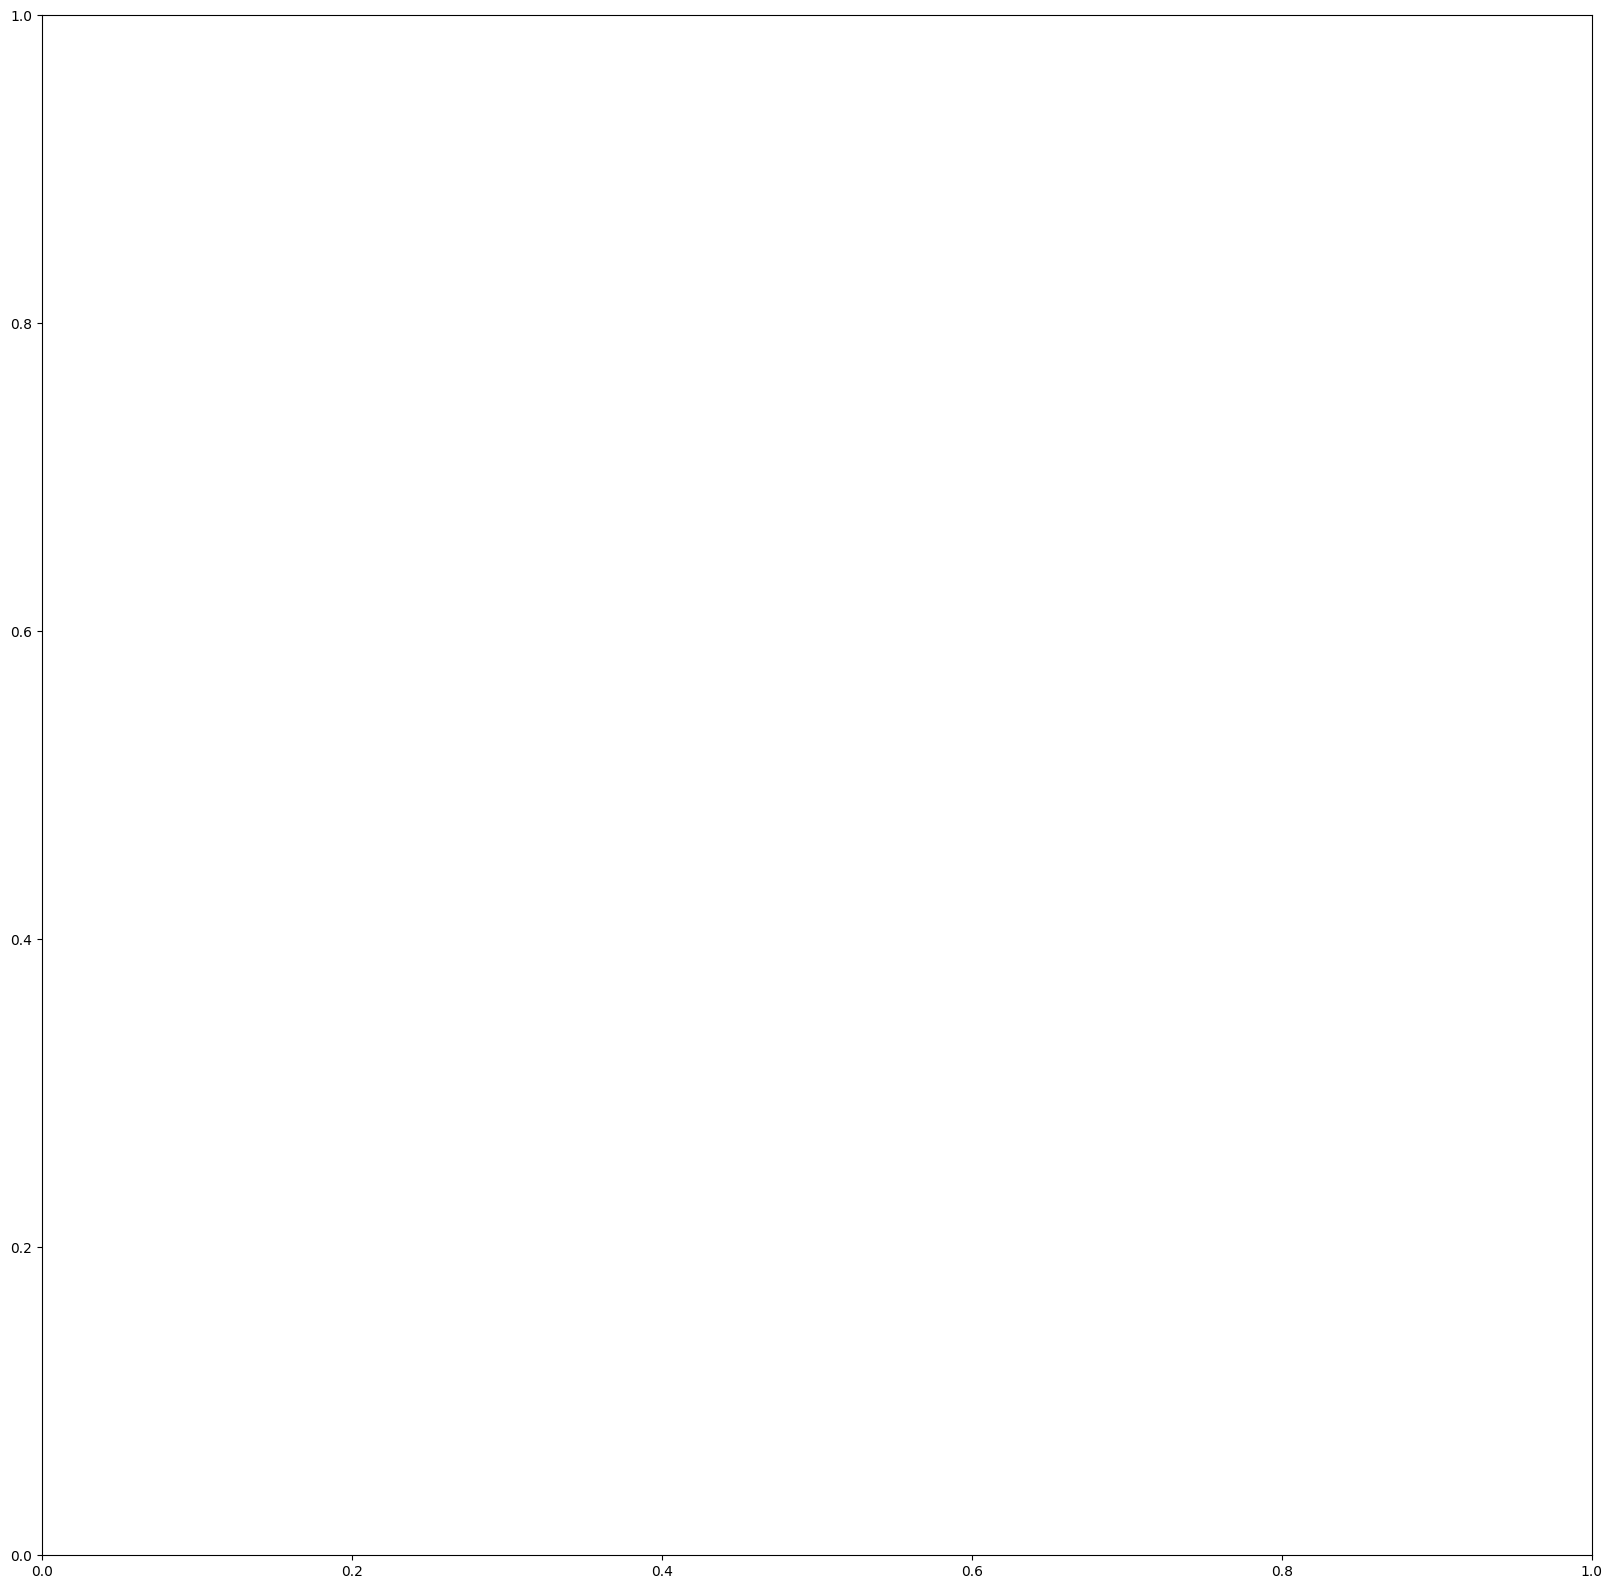

In [15]:
fig, ax = plt.pyplot.subplots(figsize=(20, 20))
correlation_matrix = train_df.corr()

# Filter out features not in selected_features
remaining_features = [col for col in correlation_matrix.columns if col not in irrel2]
# Create a subset DataFrame
subset_df = train_df[remaining_features]

# Sort columns by mean correlation values
sorted_columns = subset_df.abs().mean().sort_values().index

# Reindex the DataFrame
reordered_df = train_df.reindex(columns=sorted_columns)

# hm = sns.heatmap(reordered_df.corr(), cbar=True, vmin=-1, vmax=1,
#                  fmt='.1f', annot_kws={'size': 0.5}, annot=True, linewidths=0.07, cmap="RdBu")
# corr = reordered_df.iloc[:, 1:].corr()
# ticks = np.arange(corr.shape[0]) + 0.5
# ax.set_xticks(ticks)
# ax.set_xticklabels(corr.columns, rotation=90, fontsize=1)
# ax.set_yticks(ticks)
# ax.set_yticklabels(corr.index, rotation=360, fontsize=1)

# ax.set_title('correlation matrix')
# plt.pyplot.tight_layout()
# plt.pyplot.savefig("iowa_corr2.png", dpi=2000)

In [16]:
# reordered_df['CentralAir'].unique()

In [17]:
# mean_corr.head(232)

In [18]:
# df2 = train_df.copy()
# df2.columns = "c_" + df2.columns
# df3 = pd.concat([train_df, df2], axis=1)

# # get the correlation coefficient between the different columns
# corr = df3.iloc[:, 1:].corr()
# arr_corr = corr.to_numpy()
# # mask out the top triangle
# arr_corr[np.triu_indices_from(arr_corr)] = np.nan

# fig, ax = plt.pyplot.subplots(figsize=(23, 16))

# hm = sns.heatmap(arr_corr, cbar=True, vmin=-1, vmax=1,
#                  fmt='.1f', annot_kws={'size': 0.5}, annot=True, linewidths=0.07,
#                  square=True, cmap="RdBu")

# ticks = np.arange(corr.shape[0]) + 0.5
# ax.set_xticks(ticks)
# ax.set_xticklabels(corr.columns, rotation=90, fontsize=1)
# ax.set_yticks(ticks)
# ax.set_yticklabels(corr.index, rotation=360, fontsize=1)

# ax.set_title('correlation matrix')
# plt.pyplot.tight_layout()
# plt.pyplot.savefig("corr_matrix_incl_anno_double.png", dpi=2000)

In [19]:
# plt.pyplot.tight_layout()
# plt.pyplot.savefig("corr_matrix_incl_anno_double.png", dpi=3000)

In [20]:
# plt.pyplot.savefig('heatmap.png')

In [52]:
# Split the data into X and y
X_train = reordered_df.drop(columns=['SalePrice','HouseStyle_2.5Fin'])
y_train = reordered_df['SalePrice']
quais = [col for col in reordered_df.columns]
quais.remove('SalePrice')
quais.remove('HouseStyle_2.5Fin')
X_test = test_df[quais]

In [56]:
X_test.columns

Index(['Exterior1st_CBlock', 'Exterior2nd_CBlock', 'Heating_Wall',
       'Street_Grvl', 'Condition2_Feedr', 'Heating_Grav',
       'Exterior2nd_Brk Cmn', 'GarageType_CarPort', 'MSZoning_C (all)',
       'MSSubClass_180',
       ...
       'BsmtFinSF1', 'GarageArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 'LotArea'],
      dtype='object', length=180)

In [57]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# GAN Model
epochs = 300


In [67]:
y_train = y_train.values.reshape(-1, 1, 1)

In [74]:
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])

In [75]:
y_train.shape

(1460, 1, 1)

In [72]:
# Generator Model
generator = Sequential()
generator.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
generator.add(Dropout(0.2))
generator.add(LSTM(units=50))
generator.add(Dense(units=1))

# Discriminator Model
discriminator = Sequential()
discriminator.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
discriminator.add(Dropout(0.2))
discriminator.add(LSTM(units=50))
discriminator.add(Dense(units=1, activation='sigmoid'))

# Compile both models
generator.compile(optimizer=Adam(), loss='mean_squared_error')
discriminator.compile(optimizer=Adam(), loss='binary_crossentropy')

# Training GAN
for epoch in range(epochs):
    # Train discriminator
    real_data = y_train
    fake_data = generator.predict(X_train)
    discriminator.train_on_batch(real_data, np.ones((real_data.shape[0], 1)))
    discriminator.train_on_batch(fake_data, np.zeros((fake_data.shape[0], 1)))

    # Train generator
    noise = np.random.normal(0, 1, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    generator.train_on_batch(noise, np.ones((noise.shape[0], 1)))

# Evaluate model
predictions = generator.predict(X_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 1 and 180 for '{{node sequential_12_1/lstm_23_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_12_1/lstm_23_1/strided_slice_1, sequential_12_1/lstm_23_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [1460,1], [180,200].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(1460, 1), dtype=float32)
  • states=('tf.Tensor(shape=(1460, 50), dtype=float32)', 'tf.Tensor(shape=(1460, 50), dtype=float32)')
  • training=True